### Optimal control of the ALN model
This notebook shows how to compute the optimal control (OC) signal for the ALN model for a simple example task.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy

# We import the model, stimuli, and the optimal control package
from neurolib.models.aln import ALNModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.control.optimal_control import oc_aln
from neurolib.control.optimal_control.oc_utils.plot_oc import plot_oc_nw, plot_oc_singlenode

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2


# This function reads out the final state of a simulation
def getfinalstate(model):
    N = model.params.Cmat.shape[0]
    V = len(model.state_vars)
    T = model.getMaxDelay() + 1
    state = np.zeros((N, V, T))
    for v in range(V):
        if "rates" in model.state_vars[v] or "IA" in model.state_vars[v]:
            for n in range(N):
                state[n, v, :] = model.state[model.state_vars[v]][n, -T:]
        else:
            for n in range(N):
                state[n, v, :] = model.state[model.state_vars[v]][n]
    return state


def setinitstate(model, state):
    N = model.params.Cmat.shape[0]
    V = len(model.init_vars)
    T = model.getMaxDelay() + 1

    for n in range(N):
        for v in range(V):
            if "rates" in model.init_vars[v] or "IA" in model.init_vars[v]:
                model.params[model.init_vars[v]] = state[:, v, -T:]
            else:
                model.params[model.init_vars[v]] = state[:, v, -1]

    return

def getstate(model):
    state = np.concatenate(  ( np.concatenate((model.params["rates_exc_init"][:, np.newaxis, -1],
                                            model.params["rates_inh_init"][:, np.newaxis, -1],
                                            model.params["IA_init"][:, np.newaxis, -1], ), axis=1, )[:, :, np.newaxis],
                            np.stack((model.rates_exc, model.rates_inh, model.IA), axis=1),),axis=2,  )
    
    return state

def getperiods(model, N, x, prominence):
    timing_list = [None] * N
    periods_list = [None] * N

    for n in range(N):
        timing_list[n] = scipy.signal.find_peaks(x[n, 0, 300:], prominence=prominence)[0]
        periods_list[n] = []
        if len(timing_list[n]) < 3:
            continue
        for pind in range(1, len(timing_list[n])):
            periods_list[n].append(model.params.dt * (timing_list[n][pind]-timing_list[n][pind-1]))

    return timing_list, periods_list

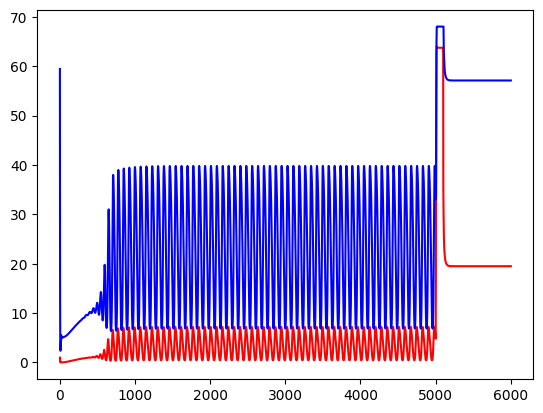

period =  78.35000000000001
rates_exc_init [[0.0095108]]
rates_inh_init [[0.00780017]]
mufe_init [0.97253361]
mufi_init [2.00713696]
IA_init [[147.04499111]]
seem_init [0.17894231]
seim_init [0.05548227]
siem_init [0.02887153]
siim_init [0.04328706]
seev_init [0.00050264]
seiv_init [0.00049709]
siev_init [0.00424775]
siiv_init [0.00879824]
mue_ou [0.4]
mui_ou [0.3]
0  19.498
1  57.104
2  0.871
3  1.934
4  0.000
5  0.794
6  0.896
7  0.783
8  0.946
9  0.002
10  0.001
11  0.002
12  0.000
13  1.900
14  1.450


In [105]:
# bistable regime down/osc between 0.35/0.4 - 0.25/0.3
model = ALNModel()
dir = "images_1n"

dt = model.params["dt"]
duration = 6000.
model.params.duration = duration
input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
#input[0,:1000] = -1.
input[0,50000:51000] = 1e0
model.params.ext_exc_current = input

eext = 0.38
iext = 0.29
model.params.mue_ext_mean = eext * 5.
model.params.mui_ext_mean = iext * 5.
model.run()

targete = model.rates_exc[0,30000:50000]
targeti = model.rates_inh[0,30000:50000]

plt.plot(model.t, model.rates_exc[0,:], color="red")
plt.plot(model.t, model.rates_inh[0,:], color="blue")
plt.show()

peaks = scipy.signal.find_peaks(model.rates_exc[0,20000:49000])[0]
periods = []
for pind in range(1,len(peaks)):
    periods.append(peaks[pind] - peaks[pind-1])

period = np.mean(periods) * dt
print("period = ", period)

for iv in model.init_vars:
    print(iv, model.params[iv])

finalstate = getfinalstate(model)
for v in range(15):
    print(v, " {:.3f}".format(finalstate[0,v,-1],3))
setinitstate(model, finalstate)

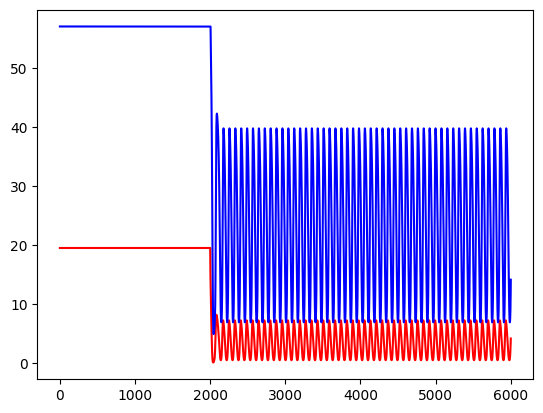

In [115]:
inpute = ZeroInput().generate_input(duration=duration+dt, dt=dt)
inputi = ZeroInput().generate_input(duration=duration+dt, dt=dt)

#inpute[0,10000:20000] = 1.
inpute[0,20000:20600] = -0.2
#inpute[0,20000:22000] = -2.
#inputi[0,10000:15000] = 2.

model.params.ext_exc_current = inpute
model.params.ext_inh_current = inputi

model.run()

plt.plot(model.t, model.rates_exc[0,:], color="red")
plt.plot(model.t, model.rates_inh[0,:], color="blue")
plt.show()

In [98]:
N = model.params.N 

controlmat = np.zeros((N,2))
controlmat[:,0] = 1.
controlmat[:,1] = 1.
costmat = np.zeros((N, len(model.output_vars)))
costmat[:,0] = 1.
costmat[:,1] = 1.

duration = 1000.
model.params.duration = duration
zero_input0 = ZeroInput().generate_input(duration=duration+model.params.dt, dt=model.params.dt)
zero_input = np.vstack( ([zero_input0]*2) )[np.newaxis,:,:]
zero_control = np.vstack( ([zero_input]*N))

zero_target0 = np.vstack( ([zero_input0]*3) )[np.newaxis,:,:]
zero_target = np.vstack( ([zero_target0]*N))

print(zero_input0.shape, zero_input.shape, zero_control.shape)

w2_array = [1e-1, 1e-2, 1e-3]

results = dict()
results["controls"] = [ [ None, None, None], [None, None, None], [None, None, None], [None, None, None], ]
results["periods"] =  [ [ None, None, None], [None, None, None], [None, None, None], [None, None, None], ]
results["timings"] =  [ [ None, None, None], [None, None, None], [None, None, None], [None, None, None], ]

(1, 10001) (1, 2, 10001) (1, 2, 10001)


In [103]:
it = 10
pr = np.arange(0,101,10)
maxstr = 10.
nmaxdel = model.getMaxDelay()
init_control = zero_control.copy()

model.params.duration = duration
zero_input = ZeroInput().generate_input(duration=duration+model.params.dt, dt=model.params.dt)
model.params.ext_exc_current = zero_input
model.params.ext_inh_current = zero_input
model.run()

target_period = period
target = zero_target.copy()
target[0,0,:] = targete[:10001]
target[0,1,:] = targeti[:10001]
i00 = 0
int0 = 1000
int1 = 10000

for imet in range(4):
    if imet != 0:
        continue

    print("imet = ", imet)

    for iw in range(len(w2_array)):
        if iw != 0:
            continue

        print("iw = ", iw)
  
        w2 = w2_array[iw]

        model_controlled = oc_aln.OcAln(model, target_period, print_array=pr, cost_interval=(int0,int1), control_interval=(1000,1100), cost_matrix=costmat, control_matrix = controlmat)
        model_controlled.maximum_control_strength = maxstr
        #model_controlled.step = 1e-5
        model_controlled.weights["w_p"] = 0.0
        # model_controlled.weights["w_2"] = w2

        if imet in [1,2,3]:
            init_control = zero_control.copy()
            tarray = np.arange(int0*dt, int0*dt + 2.*target_period, dt)
            init_control[0,0,int0:int0+len(tarray)] = np.sin(2.*np.pi *tarray/target_period)
            init_control[0,1,int0:int0+len(tarray)] = np.sin(2.*np.pi *tarray/target_period)

        model_controlled.control = init_control.copy()
        model_controlled.update_input()

        if imet == 0:
            model_controlled.weights["w_f"] = 1.
        elif imet == 1:
            model_controlled.weights["w_ac"] = 1.
        elif imet == 2:
            model_controlled.weights["w_phase"] = 1.
        elif imet == 3:
            model_controlled.weights["w_var_osc"] = 1.

        #model_controlled.weights["w_f"] = 0.

        if type(results["controls"][imet][iw]) != type(None):
            model_controlled.control = results["controls"][imet][iw].copy()
            model_controlled.update_input()

        model_controlled.optimize(it)
        results["controls"][imet][iw] = model_controlled.control.copy()

        timings, periods = getperiods(model_controlled.model, N, model_controlled.get_xs(), 0.01)
        results["timings"][imet][iw] = timings
        results["periods"][imet][iw] = periods

        fname = str(imet) + "_" + str(iw) + ".png"

        plot_oc_singlenode(duration, dt, model_controlled.get_xs(), target,  model_controlled.control, savepath= os.path.join(dir, fname))

        #if imet in [0,1,2]: plot_oc_nw(N, duration, dt, model_controlled.get_xs(), target_period,  model_controlled.control, filename= os.path.join(dir, fname))
        #else: plot_oc_nw(N, duration, dt, model_controlled.get_xs(), duration,  model_controlled.control, filename= os.path.join(dir, fname))

imet =  0
iw =  0
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -1.195424899228237


KeyboardInterrupt: 

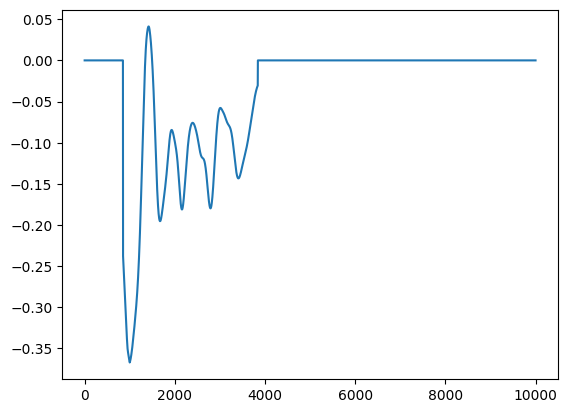

In [79]:
control_signal = model_controlled.control.copy()

control_signal[:,:,3840:] = 0.
control_signal[:,:,:850] = 0.

plt.plot(control_signal[0,0,:])
plt.show()

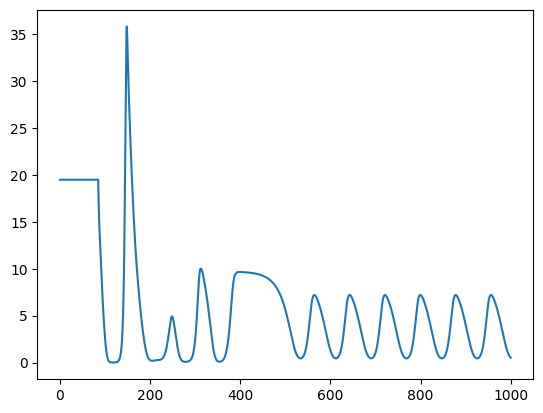

In [80]:
model.params.duration = duration
model.params.ext_exc_current = control_signal[:,0,:].copy()
model.params.ext_inh_current = control_signal[:,1,:].copy()

model.run()
plt.plot(model.t, model.rates_exc[0,:])
plt.show()